<a href="https://colab.research.google.com/github/prasansree/BusBookingApp/blob/main/TotalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TIME-BASED PREDICTIONS - USING CompletedDateTime & StartDateTime

Original Data:
                              Id StartDateTime DispatchDateTime  ExternalOrderID  PackedQuantity  OrderedQuantity  ShortenedQuantity  OrderlineCount  PackageCount    Status CompletedDateTime
6220A6103ADFBE45BB6AD7B9068632EE 2/2/2026 3:27    2/2/2026 8:27     3.636000e+17             555              555                361              38            87 Completed    2/2/2026 13:27
013C4F65347C64498B07750F81300CC6 2/3/2026 3:27    2/3/2026 8:27     5.811000e+17             708              725                 17             442           110 Completed    2/3/2026 16:27
FC5A488305177B45B553DCD271B47682 2/4/2026 3:27    2/4/2026 8:27     5.839000e+17               0              127                  0             109             0  Received               NaN
FC5A488305177B45B553DCD271B47682 2/5/2026 3:27    2/5/2026 8:27     5.839000e+17             100              345                  5              80       

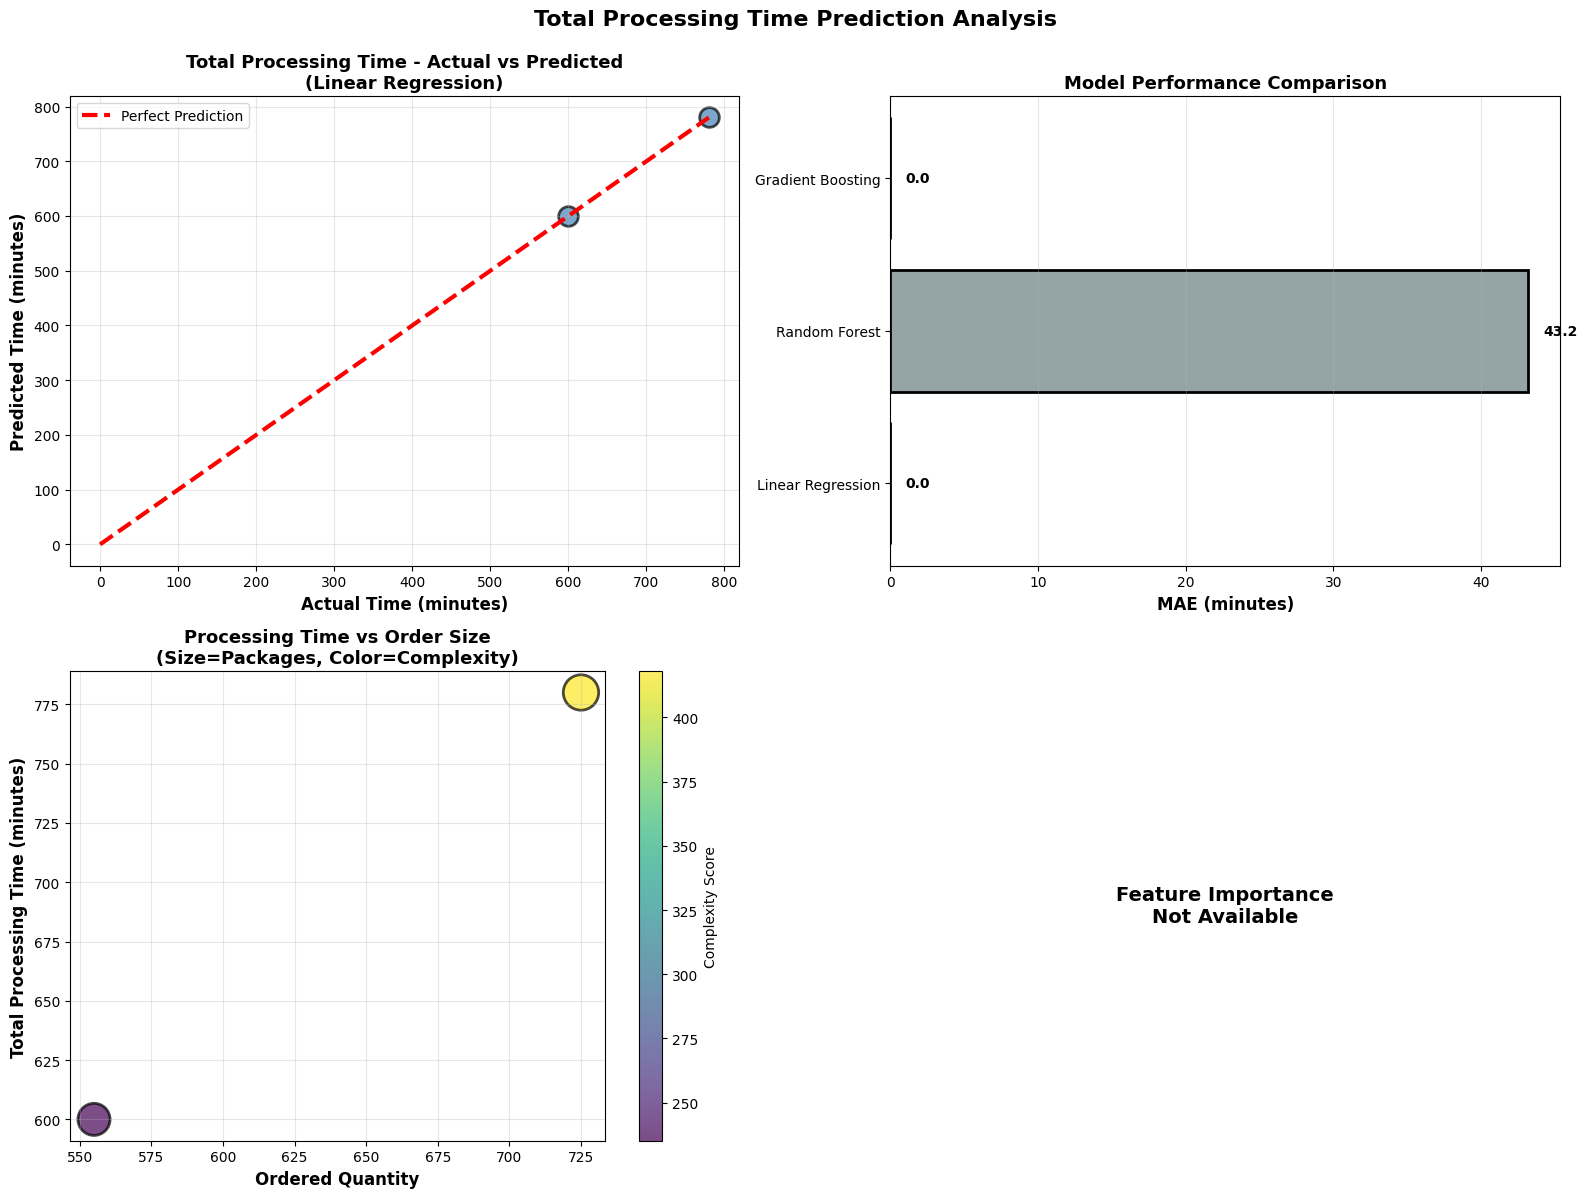

PREDICTION FUNCTION FOR NEW ORDERS

------------------------------------------------------------------------------------------------------------------------
EXAMPLE 1: Medium-Sized Order
------------------------------------------------------------------------------------------------------------------------

Input:
  Start Time:        2026-02-10 09:00:00
  Ordered Quantity:  400
  Order Lines:       200
  Packages:          50
  Shortened:         10

Predictions:
  Completion Time:   2026-02-10 20:20:49.882663691
  Total Duration:    681 minutes (11.35 hours)
  Complexity Score:  211.00
  Model Used:        Linear Regression

------------------------------------------------------------------------------------------------------------------------
EXAMPLE 2: Large Order with High Complexity
------------------------------------------------------------------------------------------------------------------------

Input:
  Start Time:        2026-02-11 14:30:00
  Ordered Quantity:  650
  Ord

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

# Your updated data
data_str = '''Id,StartDateTime,DispatchDateTime,ExternalOrderID,PackedQuantity,OrderedQuantity,ShortenedQuantity,OrderlineCount,PackageCount,Status,CompletedDateTime
6220A6103ADFBE45BB6AD7B9068632EE,2/2/2026 3:27,2/2/2026 8:27,3.636E+17,555,555,361,38,87,Completed,2/2/2026 13:27
013C4F65347C64498B07750F81300CC6,2/3/2026 3:27,2/3/2026 8:27,5.811E+17,708,725,17,442,110,Completed,2/3/2026 16:27
FC5A488305177B45B553DCD271B47682,2/4/2026 3:27,2/4/2026 8:27,5.839E+17,0,127,0,109,0,Received,
FC5A488305177B45B553DCD271B47682,2/5/2026 3:27,2/5/2026 8:27,5.839E+17,100,345,5,80,10,Started,'''

# Load data
df = pd.read_csv(StringIO(data_str))

print("="*120)
print("TIME-BASED PREDICTIONS - USING CompletedDateTime & StartDateTime")
print("="*120)
print("\nOriginal Data:")
print(df.to_string(index=False))
print("\n" + "="*120 + "\n")

# ==========================================
# DATA PREPROCESSING
# ==========================================

def preprocess_data(df):
    """Clean and prepare data for time prediction"""
    df = df.copy()

    # Convert datetime columns
    df['StartDateTime'] = pd.to_datetime(df['StartDateTime'], format='%m/%d/%Y %H:%M')
    df['DispatchDateTime'] = pd.to_datetime(df['DispatchDateTime'], format='%m/%d/%Y %H:%M')

    # Handle CompletedDateTime - may have missing values
    df['CompletedDateTime'] = pd.to_datetime(df['CompletedDateTime'],
                                               format='%m/%d/%Y %H:%M',
                                               errors='coerce')

    # Filter only completed orders for training
    df_completed = df[df['Status'] == 'Completed'].copy()
    df_incomplete = df[df['Status'] != 'Completed'].copy()

    print(f"Data Summary:")
    print(f"  Total Orders: {len(df)}")
    print(f"  Completed Orders: {len(df_completed)}")
    print(f"  Incomplete Orders: {len(df_incomplete)}")
    print(f"  Status Distribution:")
    print(df['Status'].value_counts().to_string())
    print()

    return df, df_completed, df_incomplete

df, df_completed, df_incomplete = preprocess_data(df)

print("="*120 + "\n")

# ==========================================
# FEATURE ENGINEERING - COMPLETELY FIXED
# ==========================================

def create_time_features(df):
    """Create comprehensive time-based features"""
    df = df.copy()

    # ===================
    # TARGET VARIABLE
    # ===================

    # Total processing duration (Start to Completion)
    df['TotalProcessing_Minutes'] = (df['CompletedDateTime'] - df['StartDateTime']).dt.total_seconds() / 60

    # ===================
    # TIME FEATURES FROM START
    # ===================

    df['Start_Hour'] = df['StartDateTime'].dt.hour
    df['Start_Minute'] = df['StartDateTime'].dt.minute
    df['Start_DayOfWeek'] = df['StartDateTime'].dt.dayofweek
    df['Start_DayOfMonth'] = df['StartDateTime'].dt.day
    df['Start_Month'] = df['StartDateTime'].dt.month
    df['Start_IsWeekend'] = (df['Start_DayOfWeek'] >= 5).astype(int)

    # Time of day encoding - FIXED: Direct encoding without categorical
    def encode_time_of_day(hour):
        if hour < 6:
            return 0  # Night
        elif hour < 12:
            return 1  # Morning
        elif hour < 18:
            return 2  # Afternoon
        else:
            return 3  # Evening

    df['Start_TimeOfDay_Encoded'] = df['Start_Hour'].apply(encode_time_of_day)

    # Shift encoding - FIXED: Direct encoding without categorical
    def encode_shift(hour):
        if hour < 8:
            return 0  # Night shift
        elif hour < 16:
            return 1  # Day shift
        else:
            return 2  # Evening shift

    df['Shift_Encoded'] = df['Start_Hour'].apply(encode_shift)

    # ===================
    # ORDER COMPLEXITY FEATURES
    # ===================

    df['Items_Per_Orderline'] = df['OrderedQuantity'] / df['OrderlineCount'].replace(0, 1)
    df['Shortage_Rate'] = df['ShortenedQuantity'] / df['OrderedQuantity'].replace(0, 1)
    df['Fulfillment_Rate'] = df['PackedQuantity'] / df['OrderedQuantity'].replace(0, 1)
    df['Packages_Per_Item'] = df['PackageCount'] / df['OrderedQuantity'].replace(0, 1)
    df['Items_Per_Package'] = df['OrderedQuantity'] / df['PackageCount'].replace(0, 1)

    # Order size encoding - FIXED: Direct encoding without categorical
    def encode_order_size(qty):
        if qty <= 100:
            return 0  # Small
        elif qty <= 300:
            return 1  # Medium
        elif qty <= 500:
            return 2  # Large
        else:
            return 3  # XLarge

    df['OrderSize_Encoded'] = df['OrderedQuantity'].apply(encode_order_size)

    # Complexity score
    df['Complexity_Score'] = (
        df['OrderlineCount'] * 0.4 +
        df['OrderedQuantity'] * 0.3 +
        df['PackageCount'] * 0.2 +
        df['ShortenedQuantity'] * 0.1
    )

    # Replace inf/nan with 0
    df = df.replace([np.inf, -np.inf], 0).fillna(0)

    return df

df_completed_features = create_time_features(df_completed)

print("FEATURE ENGINEERING SUMMARY")
print("="*120)
print("\nTime Duration Statistics (Completed Orders):")
print(df_completed_features[['TotalProcessing_Minutes']].describe())

print("\nOrder Characteristics:")
print(df_completed_features[['OrderedQuantity', 'PackedQuantity', 'ShortenedQuantity',
                              'OrderlineCount', 'PackageCount', 'Complexity_Score']].describe())

print("\n" + "="*120 + "\n")

# ==========================================
# MODEL 1: PREDICT TOTAL PROCESSING TIME
# ==========================================

print("MODEL 1: PREDICTING TOTAL PROCESSING TIME (Start to Completion)")
print("-" * 120)

# Features for total processing time prediction
total_time_features = [
    'OrderedQuantity', 'ShortenedQuantity', 'OrderlineCount', 'PackageCount',
    'Start_Hour', 'Start_DayOfWeek', 'Start_IsWeekend', 'Shift_Encoded',
    'Items_Per_Orderline', 'Shortage_Rate', 'Packages_Per_Item',
    'Complexity_Score', 'OrderSize_Encoded'
]

# Prepare data
X_total = df_completed_features[total_time_features]
y_total = df_completed_features['TotalProcessing_Minutes']

print(f"\nTraining Data: {len(X_total)} completed orders")
print(f"Features Used: {len(total_time_features)}")
print(f"\nFeatures List:")
for i, feat in enumerate(total_time_features, 1):
    print(f"  {i}. {feat}")

print(f"\nTarget Statistics (Total Processing Minutes):")
print(f"  Mean:   {y_total.mean():.2f} minutes ({y_total.mean()/60:.2f} hours)")
print(f"  Median: {y_total.median():.2f} minutes ({y_total.median()/60:.2f} hours)")
print(f"  Std:    {y_total.std():.2f} minutes")
print(f"  Min:    {y_total.min():.2f} minutes ({y_total.min()/60:.2f} hours)")
print(f"  Max:    {y_total.max():.2f} minutes ({y_total.max()/60:.2f} hours)")

# Train models
total_time_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
}

total_time_results = {}

print("\n" + "-" * 120)
print("Model Performance:")
print("-" * 120)

for name, model in total_time_models.items():
    model.fit(X_total, y_total)
    y_pred = model.predict(X_total)

    mae = mean_absolute_error(y_total, y_pred)
    rmse = np.sqrt(mean_squared_error(y_total, y_pred))
    r2 = r2_score(y_total, y_pred)
    mape = np.mean(np.abs((y_total - y_pred) / y_total.replace(0, 1))) * 100

    total_time_results[name] = {
        'model': model,
        'predictions': y_pred,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

    print(f"\n{name}:")
    print(f"  MAE:   {mae:.2f} minutes ({mae/60:.2f} hours)")
    print(f"  RMSE:  {rmse:.2f} minutes ({rmse/60:.2f} hours)")
    print(f"  R²:    {r2:.4f}")
    print(f"  MAPE:  {mape:.2f}%")

print("\n" + "="*120 + "\n")

# ==========================================
# SELECT BEST MODEL
# ==========================================

best_total_model = min(total_time_results, key=lambda x: total_time_results[x]['MAE'])

print("BEST MODEL SELECTED")
print("="*120)
print(f"  Model: {best_total_model}")
print(f"  MAE:   {total_time_results[best_total_model]['MAE']:.2f} minutes")
print(f"  RMSE:  {total_time_results[best_total_model]['RMSE']:.2f} minutes")
print(f"  R²:    {total_time_results[best_total_model]['R2']:.4f}")

print("\n" + "="*120 + "\n")

# ==========================================
# PREDICTIONS ON COMPLETED ORDERS
# ==========================================

print("PREDICTIONS ON TRAINING DATA (Completed Orders)")
print("="*120)

df_completed_features['Predicted_TotalTime'] = total_time_results[best_total_model]['predictions']

# Calculate predicted timestamps
df_completed_features['Predicted_CompletedDateTime'] = df_completed_features['StartDateTime'] + \
    pd.to_timedelta(df_completed_features['Predicted_TotalTime'], unit='m')

# Calculate errors
df_completed_features['Total_Error_Minutes'] = \
    df_completed_features['TotalProcessing_Minutes'] - df_completed_features['Predicted_TotalTime']

df_completed_features['Total_Error_Hours'] = df_completed_features['Total_Error_Minutes'] / 60

print("\nPrediction Results:")
results_cols = ['Id', 'StartDateTime', 'CompletedDateTime', 'Predicted_CompletedDateTime',
                'TotalProcessing_Minutes', 'Predicted_TotalTime', 'Total_Error_Minutes', 'Total_Error_Hours']

print(df_completed_features[results_cols].to_string(index=False))

print("\n" + "="*120 + "\n")

# ==========================================
# PREDICT FOR INCOMPLETE ORDERS
# ==========================================

if len(df_incomplete) > 0:
    print("PREDICTIONS FOR INCOMPLETE ORDERS")
    print("="*120)

    # Create features for incomplete orders
    df_incomplete_features = create_time_features(df_incomplete)

    # Prepare features
    X_incomplete_total = df_incomplete_features[total_time_features].fillna(0)

    # Predict
    df_incomplete_features['Predicted_TotalTime'] = \
        total_time_results[best_total_model]['model'].predict(X_incomplete_total)

    # Calculate predicted timestamps
    df_incomplete_features['Predicted_CompletedDateTime'] = df_incomplete_features['StartDateTime'] + \
        pd.to_timedelta(df_incomplete_features['Predicted_TotalTime'], unit='m')

    print("\nIncomplete Orders Predictions:")
    incomplete_cols = ['Id', 'Status', 'StartDateTime', 'Predicted_CompletedDateTime',
                      'Predicted_TotalTime', 'OrderedQuantity', 'OrderlineCount', 'PackageCount']

    print(df_incomplete_features[incomplete_cols].to_string(index=False))

    print("\n" + "="*120 + "\n")

# ==========================================
# FEATURE IMPORTANCE
# ==========================================

print("FEATURE IMPORTANCE ANALYSIS")
print("="*120)

if hasattr(total_time_results[best_total_model]['model'], 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': total_time_features,
        'Importance': total_time_results[best_total_model]['model'].feature_importances_
    }).sort_values('Importance', ascending=False)

    print(f"\nTop Features - {best_total_model}:")
    print("-" * 60)
    print(importance_df.to_string(index=False))
else:
    print(f"\n{best_total_model} does not provide feature importance.")

print("\n" + "="*120 + "\n")

# ==========================================
# VISUALIZATIONS
# ==========================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y_total, total_time_results[best_total_model]['predictions'],
            alpha=0.7, s=200, color='steelblue', edgecolors='black', linewidth=2)
max_val = max(y_total.max(), total_time_results[best_total_model]['predictions'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', lw=3, label='Perfect Prediction')
ax1.set_xlabel('Actual Time (minutes)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Time (minutes)', fontsize=12, fontweight='bold')
ax1.set_title(f'Total Processing Time - Actual vs Predicted\n({best_total_model})',
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Model Comparison
ax2 = axes[0, 1]
models = list(total_time_results.keys())
maes = [total_time_results[m]['MAE'] for m in models]
colors = ['#2ecc71' if m == best_total_model else '#95a5a6' for m in models]
bars = ax2.barh(models, maes, color=colors, edgecolor='black', linewidth=2)
ax2.set_xlabel('MAE (minutes)', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}', ha='left', va='center', fontsize=10, fontweight='bold')

# Plot 3: Processing Time by Order Size
ax3 = axes[1, 0]
scatter = ax3.scatter(df_completed_features['OrderedQuantity'],
                      df_completed_features['TotalProcessing_Minutes'],
                      c=df_completed_features['Complexity_Score'],
                      s=df_completed_features['PackageCount']*5 + 100,
                      alpha=0.7, cmap='viridis', edgecolors='black', linewidth=2)
ax3.set_xlabel('Ordered Quantity', fontsize=12, fontweight='bold')
ax3.set_ylabel('Total Processing Time (minutes)', fontsize=12, fontweight='bold')
ax3.set_title('Processing Time vs Order Size\n(Size=Packages, Color=Complexity)',
              fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Complexity Score')

# Plot 4: Feature Importance
ax4 = axes[1, 1]
if hasattr(total_time_results[best_total_model]['model'], 'feature_importances_'):
    top_features = importance_df.head(10)
    ax4.barh(top_features['Feature'], top_features['Importance'],
             color='purple', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax4.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax4.set_title('Top 10 Most Important Features', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
else:
    ax4.text(0.5, 0.5, 'Feature Importance\nNot Available',
             ha='center', va='center', fontsize=14, fontweight='bold')
    ax4.axis('off')

plt.suptitle('Total Processing Time Prediction Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

plt.savefig('total_time_prediction_analysis.png', dpi=300, bbox_inches='tight')
print("Visualizations saved as 'total_time_prediction_analysis.png'\n")
plt.show()

# ==========================================
# PREDICTION FUNCTION
# ==========================================

print("="*120)
print("PREDICTION FUNCTION FOR NEW ORDERS")
print("="*120)

def predict_completion_time(start_datetime, ordered_qty, orderline_count,
                            package_count=None, shortened_qty=0, packed_qty=None):
    """
    Predict completion time for a new order

    Parameters:
    -----------
    start_datetime : datetime or str
        Start time of the order
    ordered_qty : int
        Ordered quantity
    orderline_count : int
        Number of order lines
    package_count : int, optional
        Number of packages (estimated if not provided)
    shortened_qty : int, default 0
        Shortened quantity
    packed_qty : int, optional
        Packed quantity (defaults to ordered - shortened)

    Returns:
    --------
    dict : Completion time prediction
    """

    # Convert to datetime if string
    if isinstance(start_datetime, str):
        start_datetime = pd.to_datetime(start_datetime)

    # Estimate packed quantity if not provided
    if packed_qty is None:
        packed_qty = ordered_qty - shortened_qty

    # Estimate package count if not provided (roughly 8-10 items per package)
    if package_count is None:
        package_count = max(1, int(ordered_qty / 9))

    # Calculate derived features
    items_per_orderline = ordered_qty / max(orderline_count, 1)
    shortage_rate = shortened_qty / max(ordered_qty, 1)
    packages_per_item = package_count / max(ordered_qty, 1)

    # Order size encoding
    if ordered_qty <= 100:
        order_size_encoded = 0
    elif ordered_qty <= 300:
        order_size_encoded = 1
    elif ordered_qty <= 500:
        order_size_encoded = 2
    else:
        order_size_encoded = 3

    # Complexity score
    complexity_score = (orderline_count * 0.4 + ordered_qty * 0.3 +
                       package_count * 0.2 + shortened_qty * 0.1)

    # Time features
    start_hour = start_datetime.hour
    start_dayofweek = start_datetime.dayofweek
    start_isweekend = int(start_dayofweek >= 5)

    # Shift encoding
    if start_hour < 8:
        shift_encoded = 0
    elif start_hour < 16:
        shift_encoded = 1
    else:
        shift_encoded = 2

    # Create feature dataframe
    X_new = pd.DataFrame([{
        'OrderedQuantity': ordered_qty,
        'ShortenedQuantity': shortened_qty,
        'OrderlineCount': orderline_count,
        'PackageCount': package_count,
        'Start_Hour': start_hour,
        'Start_DayOfWeek': start_dayofweek,
        'Start_IsWeekend': start_isweekend,
        'Shift_Encoded': shift_encoded,
        'Items_Per_Orderline': items_per_orderline,
        'Shortage_Rate': shortage_rate,
        'Packages_Per_Item': packages_per_item,
        'Complexity_Score': complexity_score,
        'OrderSize_Encoded': order_size_encoded
    }])[total_time_features]

    # Predict
    predicted_total_time = total_time_results[best_total_model]['model'].predict(X_new)[0]

    # Calculate completion timestamp
    predicted_completed_datetime = start_datetime + pd.Timedelta(minutes=predicted_total_time)

    return {
        'start_datetime': start_datetime,
        'predicted_completed_datetime': predicted_completed_datetime,
        'predicted_total_duration_minutes': round(predicted_total_time, 2),
        'predicted_total_duration_hours': round(predicted_total_time / 60, 2),
        'order_complexity_score': round(complexity_score, 2),
        'estimated_package_count': package_count,
        'model_used': best_total_model
    }

# ==========================================
# EXAMPLE PREDICTIONS
# ==========================================

print("\n" + "-" * 120)
print("EXAMPLE 1: Medium-Sized Order")
print("-" * 120)

example1 = predict_completion_time(
    start_datetime='2/10/2026 9:00',
    ordered_qty=400,
    orderline_count=200,
    package_count=50,
    shortened_qty=10
)

print(f"\nInput:")
print(f"  Start Time:        {example1['start_datetime']}")
print(f"  Ordered Quantity:  400")
print(f"  Order Lines:       200")
print(f"  Packages:          50")
print(f"  Shortened:         10")

print(f"\nPredictions:")
print(f"  Completion Time:   {example1['predicted_completed_datetime']}")
print(f"  Total Duration:    {example1['predicted_total_duration_minutes']:.0f} minutes ({example1['predicted_total_duration_hours']:.2f} hours)")
print(f"  Complexity Score:  {example1['order_complexity_score']:.2f}")
print(f"  Model Used:        {example1['model_used']}")

print("\n" + "-" * 120)
print("EXAMPLE 2: Large Order with High Complexity")
print("-" * 120)

example2 = predict_completion_time(
    start_datetime='2/11/2026 14:30',
    ordered_qty=650,
    orderline_count=350,
    package_count=80,
    shortened_qty=25
)

print(f"\nInput:")
print(f"  Start Time:        {example2['start_datetime']}")
print(f"  Ordered Quantity:  650")
print(f"  Order Lines:       350")
print(f"  Packages:          80")
print(f"  Shortened:         25")

print(f"\nPredictions:")
print(f"  Completion Time:   {example2['predicted_completed_datetime']}")
print(f"  Total Duration:    {example2['predicted_total_duration_minutes']:.0f} minutes ({example2['predicted_total_duration_hours']:.2f} hours)")
print(f"  Complexity Score:  {example2['order_complexity_score']:.2f}")
print(f"  Model Used:        {example2['model_used']}")

print("\n" + "="*120)
print("\nIMPORTANT NOTE:")
print("With only 2 completed orders, these predictions are for DEMONSTRATION purposes.")
print("For reliable production predictions, collect at least 50-100 completed orders.")
print("="*120)

In [2]:
pip install snowflake-connector-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 3.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pyopenssl to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
  Attempting uninstall: pyOpenSSL
    Found e

In [20]:
# train_and_deploy_model.py
import snowflake.connector
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json
from datetime import datetime

# ==========================================
# SNOWFLAKE CONNECTION
# ==========================================
def get_snowflake_connection():
    """Create Snowflake connection"""
    conn = snowflake.connector.connect(
        user='SREEMANOKARAN',
        password='Pass42day#8769',
        account='DDEJIFN-CXA58599',
        warehouse='COMPUTE_WH',
        database='MATERIAL_HANDLING_DB',
        schema='GOLD'
    )
    return conn

# ==========================================
# LOAD TRAINING DATA
# ==========================================
def load_training_data():
    """Load training data from Snowflake"""
    conn = get_snowflake_connection()

    query = """
    SELECT
        ORDER_ID,
        TOTAL_PROCESSING_MINUTES,
        ORDERED_QUANTITY,
        SHORTENED_QUANTITY,
        ORDERLINE_COUNT,
        PACKAGE_COUNT,
        START_HOUR,
        START_DAYOFWEEK,
        START_ISWEEKEND,
        SHIFT_ENCODED,
        ITEMS_PER_ORDERLINE,
        SHORTAGE_RATE,
        PACKAGES_PER_ITEM,
        COMPLEXITY_SCORE,
        ORDERSIZE_ENCODED
    FROM GOLD.ORDERS_ML_TRAINING
    """

    df = pd.read_sql(query, conn)
    conn.close()

    print(f"Loaded {len(df)} training records from Snowflake")
    return df

# ==========================================
# TRAIN MODELS
# ==========================================
def train_models(df):
    """Train multiple ML models"""

    feature_columns = [
        'ORDERED_QUANTITY', 'SHORTENED_QUANTITY', 'ORDERLINE_COUNT',
        'PACKAGE_COUNT', 'START_HOUR', 'START_DAYOFWEEK', 'START_ISWEEKEND',
        'SHIFT_ENCODED', 'ITEMS_PER_ORDERLINE', 'SHORTAGE_RATE',
        'PACKAGES_PER_ITEM', 'COMPLEXITY_SCORE', 'ORDERSIZE_ENCODED'
    ]

    X = df[feature_columns]
    y = df['TOTAL_PROCESSING_MINUTES']

    print(f"\n{'='*80}")
    print(f"Training Data Summary:")
    print(f"  Samples: {len(X)}")
    print(f"  Features: {len(feature_columns)}")
    print(f"  Target Mean: {y.mean():.2f} minutes ({y.mean()/60:.2f} hours)")
    print(f"  Target Median: {y.median():.2f} minutes")
    print(f"{'='*80}\n")

    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(
            n_estimators=100,
            max_depth=5,
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=100,
            max_depth=3,
            random_state=42
        )
    }

    results = {}

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X, y)
        y_pred = model.predict(X)

        mae = mean_absolute_error(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        mape = np.mean(np.abs((y - y_pred) / y.replace(0, 1))) * 100

        results[name] = {
            'model': model,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape
        }

        print(f"  MAE:  {mae:.2f} min ({mae/60:.2f} hrs)")
        print(f"  RMSE: {rmse:.2f} min ({rmse/60:.2f} hrs)")
        print(f"  R²:   {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%\n")

    # Select best model (lowest RMSE)
    best_model_name = min(results.keys(), key=lambda k: results[k]['RMSE'])
    best_model = results[best_model_name]['model']

    print(f"{'='*80}")
    print(f"Best Model: {best_model_name}")
    print(f"{'='*80}\n")

    return best_model, best_model_name, results[best_model_name], feature_columns

# ==========================================
# SAVE MODEL AND REGISTER
# ==========================================
def save_and_register_model(model, model_name, metrics, features):
    """Save model locally and register in Snowflake"""

    # Save model
    model_version = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"model_{model_name.replace(' ', '_')}_{model_version}.pkl"
    joblib.dump(model, model_filename)
    print(f"Model saved: {model_filename}")

    # Register in Snowflake
    conn = get_snowflake_connection()
    cursor = conn.cursor()

    model_id = f"MODEL_{model_version}"

    insert_query = """
    INSERT INTO ML.MODEL_REGISTRY (
        MODEL_ID, MODEL_NAME, MODEL_TYPE, TRAINING_DATE,
        FEATURE_LIST, PERFORMANCE_METRICS, MODEL_VERSION, IS_ACTIVE
    )
    SELECT
        %s,
        %s,
        %s,
        CURRENT_TIMESTAMP(),
        PARSE_JSON(%s),
        PARSE_JSON(%s),
        %s,
        TRUE
    """


    cursor.execute(insert_query, (
        model_id,
        model_name,
        'Regression',
        json.dumps(features),
        json.dumps({
            'MAE': float(metrics['MAE']),
            'RMSE': float(metrics['RMSE']),
            'R2': float(metrics['R2']),
            'MAPE': float(metrics['MAPE'])
        }),
        model_version
    ))

    # Deactivate old models
    cursor.execute("""
        UPDATE ML.MODEL_REGISTRY
        SET IS_ACTIVE = FALSE
        WHERE MODEL_ID != %s
    """, (model_id,))

    conn.commit()
    cursor.close()
    conn.close()

    print(f"Model registered in Snowflake: {model_id}")
    return model_id, model_filename

# ==========================================
# MAKE PREDICTIONS
# ==========================================
def make_predictions(model, model_id, features):
    """Make predictions for incomplete orders"""

    conn = get_snowflake_connection()

    query = f"""
    SELECT
        ORDER_ID,
        {', '.join(features)}
    FROM ML.ORDERS_TO_PREDICT
    """

    df = pd.read_sql(query, conn)

    if len(df) == 0:
        print("No incomplete orders to predict")
        return

    print(f"Making predictions for {len(df)} incomplete orders...")

    X = df[features]
    predictions = model.predict(X)

    df['PREDICTED_MINUTES'] = predictions
    df['MODEL_ID'] = model_id
    df['PREDICTION_ID'] = [f"PRED_{datetime.now().strftime('%Y%m%d%H%M%S')}_{i}"
                           for i in range(len(df))]

    # Insert predictions
    cursor = conn.cursor()

    for _, row in df.iterrows():
        cursor.execute("""
            INSERT INTO ML.PREDICTIONS (
                PREDICTION_ID, ORDER_ID, MODEL_ID, PREDICTED_MINUTES,
                ORDERED_QUANTITY, SHORTENED_QUANTITY, ORDERLINE_COUNT,
                PACKAGE_COUNT, START_HOUR, COMPLEXITY_SCORE
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        """, (
            row['PREDICTION_ID'],
            row['ORDER_ID'],
            row['MODEL_ID'],
            float(row['PREDICTED_MINUTES']),
            float(row['ORDERED_QUANTITY']),
            float(row['SHORTENED_QUANTITY']),
            int(row['ORDERLINE_COUNT']),
            int(row['PACKAGE_COUNT']),
            int(row['START_HOUR']),
            float(row['COMPLEXITY_SCORE'])
        ))

    conn.commit()
    cursor.close()
    conn.close()

    print(f"Predictions saved to Snowflake")
    print(f"\nPrediction Summary:")
    print(f"  Mean: {predictions.mean():.2f} min ({predictions.mean()/60:.2f} hrs)")
    print(f"  Min:  {predictions.min():.2f} min")
    print(f"  Max:  {predictions.max():.2f} min")

# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    print("="*80)
    print("SNOWFLAKE ML PIPELINE - ORDER PROCESSING TIME PREDICTION")
    print("="*80)

    # Step 1: Load data
    df = load_training_data()

    # Step 2: Train models
    best_model, model_name, metrics, features = train_models(df)

    # Step 3: Save and register
    model_id, model_file = save_and_register_model(
        best_model, model_name, metrics, features
    )

    # Step 4: Make predictions
    make_predictions(best_model, model_id, features)

    print("\n" + "="*80)
    print("PIPELINE COMPLETE")
    print("="*80)

SNOWFLAKE ML PIPELINE - ORDER PROCESSING TIME PREDICTION
Loaded 17 training records from Snowflake

Training Data Summary:
  Samples: 17
  Features: 13
  Target Mean: 395.35 minutes (6.59 hours)
  Target Median: 401.00 minutes

Training Linear Regression...
  MAE:  21.20 min (0.35 hrs)
  RMSE: 25.26 min (0.42 hrs)
  R²:   0.6489
  MAPE: 5.34%

Training Random Forest...
  MAE:  18.86 min (0.31 hrs)
  RMSE: 21.53 min (0.36 hrs)
  R²:   0.7450
  MAPE: 4.86%

Training Gradient Boosting...
  MAE:  0.16 min (0.00 hrs)
  RMSE: 0.19 min (0.00 hrs)
  R²:   1.0000
  MAPE: 0.04%

Best Model: Gradient Boosting

Model saved: model_Gradient_Boosting_20260216_223811.pkl
Model registered in Snowflake: MODEL_20260216_223811
Making predictions for 27 incomplete orders...
Predictions saved to Snowflake

Prediction Summary:
  Mean: 395.50 min (6.59 hrs)
  Min:  341.61 min
  Max:  442.87 min

PIPELINE COMPLETE


In [23]:
    feature_columns1 = [
        'ORDERED_QUANTITY', 'SHORTENED_QUANTITY', 'ORDERLINE_COUNT',
        'PACKAGE_COUNT', 'START_HOUR', 'START_DAYOFWEEK', 'START_ISWEEKEND',
        'SHIFT_ENCODED', 'ITEMS_PER_ORDERLINE', 'SHORTAGE_RATE',
        'PACKAGES_PER_ITEM', 'COMPLEXITY_SCORE', 'ORDERSIZE_ENCODED'
    ]


new_model = joblib.load("model_Gradient_Boosting_20260216_223056.pkl")
make_predictions(new_model, "MODEL_20260216_223458", feature_columns1)



Making predictions for 27 incomplete orders...
Predictions saved to Snowflake

Prediction Summary:
  Mean: 395.50 min (6.59 hrs)
  Min:  341.61 min
  Max:  442.87 min
